In [1]:
import time
import gc

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [2]:
pd.set_option('mode.chained_assignment', None)

### Defining Methods

In [3]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

### Reading Data

---

In [4]:
graph_path = '../../data/actual_graph_2021-05-22.csv'
graph = pd.read_csv(graph_path)
graph.rename({'id':'graph_vertex_id'}, axis=1, inplace=True)
graph.columns

Index(['graph_vertex_id', 'graph_vertex', 'graph_vertex_subclass'], dtype='object')

In [5]:
COMPETITIONS_PATH = "../../data/competitions_info_cleaned_filled.csv" #./data/competitions_info_cleaned.csv
competitions_filled = pd.read_csv(COMPETITIONS_PATH)
competitions_filled.drop_duplicates(inplace=True)
competitions_filled.rename({'Description': 'description', 'Metric':'metric', 'DataType':'datatype', 'Subject':'subject', 'ProblemType':'problemtype'}
                        , axis=1, inplace=True)
competitions_filled.shape

(266, 8)

In [6]:
competitions_filled.isna().sum()

ref             0
comp_name       0
comp_type       0
description    21
metric         19
datatype       19
subject        19
problemtype    19
dtype: int64

In [7]:
competitions_filled['ref'] = competitions_filled['ref'].str.replace("'", "")

In [8]:
COMPETITIONS_PATH = "../../data/competitions_2021-05-22.csv" #./data/competitions_info_cleaned.csv
competitions = pd.read_csv(COMPETITIONS_PATH)
competitions.drop_duplicates(inplace=True)
competitions.shape

(5060, 10)

In [9]:
# competitions['ref'] = competitions['ref'].apply(lambda x: x.split(',')[0])
# competitions['ref'] = competitions['ref'].str.replace("'", "")

In [10]:
# competitions['exists_in_comp_filled'] = competitions.apply(lambda x: x['ref'] in competitions_filled['ref'].unique(), axis=1)
# competitions['exists_in_comp_filled'].value_counts()

In [11]:
# competitions_filled.merge(competitions[['id', 'ref']], on=['ref']).shape

In [12]:
competitions = competitions_filled.merge(competitions[['id', 'ref_link']], how='inner', left_on=['ref'], right_on=['ref_link'])
competitions.shape

(312, 10)

In [13]:
competitions.isna().sum()

ref             0
comp_name       0
comp_type       0
description    26
metric         23
datatype       23
subject        23
problemtype    23
id              0
ref_link        0
dtype: int64

In [14]:
NOTEBOOKS_PATH = '../../data/markup_data_2021-05-22.csv'
notebooks = pd.read_csv(NOTEBOOKS_PATH)
notebooks.head(5)

,code_block_id,code_block,data_format,graph_vertex_id,errors,marks,kaggle_id,competition_id
0,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868
1,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868
2,570368,`# load training and testing data \nsubm = pd....,Table,45,No,5,8591010,3868
3,570369,`subm`,Table,41,No,5,8591010,3868
4,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868


In [15]:
notebooks = notebooks.merge(graph, on='graph_vertex_id', how='left')
notebooks.shape

(5932, 10)

In [16]:
nl2ml = notebooks.merge(competitions, left_on=['competition_id'], right_on=['id'], how='inner')
print(nl2ml.shape[0])
nl2ml.drop_duplicates(inplace=True, subset=['code_block_id', 'kaggle_id'])
print(nl2ml.shape[0])

3207
3110


In [17]:
print(nl2ml['kaggle_id'].nunique(), nl2ml['competition_id'].nunique())

113 7


### Vertices Preprocessing

In [18]:
nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]).value_counts()

Data_Transform          936
EDA                     747
Model_Train             287
Visualization           281
Environment             202
Data_Extraction         167
Other                   147
Hyperparam_Tuning       120
Data_Export             104
Model_Evaluation         95
Model_Interpretation     21
Hypothesis                3
Name: graph_vertex, dtype: int64

In [19]:
nl2ml.columns

Index(['code_block_id', 'code_block', 'data_format', 'graph_vertex_id',
       'errors', 'marks', 'kaggle_id', 'competition_id', 'graph_vertex',
       'graph_vertex_subclass', 'ref', 'comp_name', 'comp_type', 'description',
       'metric', 'datatype', 'subject', 'problemtype', 'id', 'ref_link'],
      dtype='object')

In [20]:
nl2ml['vertex_l1'], nl2ml['vertex_l2'] = nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]), nl2ml['graph_vertex_subclass']#.apply(lambda x: x.split(';')[0].split('.')[1])

### Missing Values

In [21]:
nl2ml.replace('-', -1, inplace=True)
print(nl2ml.isna().sum())
nl2ml.fillna(-1, inplace=True)
print(nl2ml.isna().sum())

code_block_id            0
code_block               0
data_format              0
graph_vertex_id          0
errors                   0
marks                    0
kaggle_id                0
competition_id           0
graph_vertex             0
graph_vertex_subclass    0
ref                      0
comp_name                0
comp_type                0
description              0
metric                   0
datatype                 0
subject                  0
problemtype              0
id                       0
ref_link                 0
vertex_l1                0
vertex_l2                0
dtype: int64
code_block_id            0
code_block               0
data_format              0
graph_vertex_id          0
errors                   0
marks                    0
kaggle_id                0
competition_id           0
graph_vertex             0
graph_vertex_subclass    0
ref                      0
comp_name                0
comp_type                0
description              0
metric         

In [22]:
TASK_FEATURES = ['comp_name', 'comp_type', 'description',
                'metric', 'datatype', 'subject', 'problemtype']
# TASK_FEATURES = ['ProblemType',
#                 'number of columns (for tabular)', 'number of entries',
#                 'LabelType', 'Number of classes', 'Loss Function/Metrics',
#                 'Target Column(s) Name']

In [23]:
TARGET_COLUMN = 'vertex_l2'

### Grouping chunks by notebooks

In [273]:
notebook_id_col = 'kaggle_id'
competition_id_col = 'competition_id'
def group_by_notebooks(data:pd.DataFrame, vertex_col:str='vertex_l1') -> pd.DataFrame:
    notebook_cols = [[notebook_id_col, vertex_col, competition_id_col] + TASK_FEATURES]
    df = pd.DataFrame(columns=notebook_cols)
    for i, notebook_id in enumerate(data[notebook_id_col].unique()):
        notebook = data[data[notebook_id_col] == notebook_id].reset_index(drop=True)
        vertices_seq = " ".join(notebook[vertex_col])
        task_features = notebook[TASK_FEATURES].loc[0]
        competition_id = notebook[competition_id_col].unique()[0]
        row = [notebook_id, vertices_seq, competition_id] + task_features.tolist()
        df.loc[i] = row
        print('notebook #{} done'.format(notebook_id))
    return df

### Taking Train Features

In [489]:
# nl2ml = group_by_notebooks(nl2ml, TARGET_COLUMN)
# X, y = train[TASK_FEATURES], train[TARGET_COLUMN]
prepared_data = group_by_notebooks(nl2ml, TARGET_COLUMN)
prepared_data.shape

notebook #8591010 done
notebook #8592598 done
notebook #8596735 done
notebook #8606894 done
notebook #8609050 done
notebook #8611767 done
notebook #8630977 done
notebook #8634286 done
notebook #8640194 done
notebook #8660923 done
notebook #8667455 done
notebook #8668446 done
notebook #8678201 done
notebook #8687334 done
notebook #8689318 done
notebook #8699382 done
notebook #8705213 done
notebook #8706858 done
notebook #8708118 done
notebook #8710137 done
notebook #8710362 done
notebook #8604602 done
notebook #8617043 done
notebook #8620454 done
notebook #8625834 done
notebook #8628909 done
notebook #8658083 done
notebook #8663175 done
notebook #8671133 done
notebook #8679319 done
notebook #8682800 done
notebook #8687249 done
notebook #8693806 done
notebook #8701862 done
notebook #8702904 done
notebook #8706295 done
notebook #8711165 done
notebook #9326374 done
notebook #9349764 done
notebook #9463384 done
notebook #138832 done
notebook #2637869 done
notebook #5466844 done
notebook #57

(113, 10)

### Converting Dtypes

In [490]:
def strip_recurrent_vertices(sequence):
    return " ".join(list(set(sequence['vertex_l2'].split(' '))))
    # if len(sequence['vertex_l2'].split(' ')) > 1:
    #     return sequence['vertex_l2'].split(' ')[0] + " " + " ".join([sequence['vertex_l2'].split(' ')[i] for i in range(1, len(sequence['vertex_l2'].split(' '))) if (sequence['vertex_l2'].split(' ')[i-1] != sequence['vertex_l2'].split(' ')[i])&(sequence['vertex_l2'].split(' ')[i] != ' ')&(sequence['vertex_l2'].split(' ')[i] != '')])
    # else:
    #     return " ".join(sequence['vertex_l2'].split(' '))

In [491]:
prepared_data[TARGET_COLUMN] = prepared_data[TARGET_COLUMN].apply(strip_recurrent_vertices, axis=1)

In [492]:
prepared_data[TARGET_COLUMN].loc[61]['vertex_l2']

'load_from_csv'

In [493]:
prepared_data[TARGET_COLUMN].loc[70]['vertex_l2']

'import_modules'

In [494]:
cat_encodings = {}
for i, col in enumerate(prepared_data):
    if col[0] != TARGET_COLUMN:
        print(col)
        try:
            prepared_data[col] =  prepared_data[col].astype('float32')
        except:
            prepared_data[col] = pd.Categorical(prepared_data[col])
            cat_encodings.update({i:dict(enumerate(prepared_data[col].cat.categories))})
            prepared_data[col] = prepared_data[col].cat.codes

('kaggle_id',)
('competition_id',)
('comp_name',)
('comp_type',)
('description',)
('metric',)
('datatype',)
('subject',)
('problemtype',)


In [495]:
competitions = prepared_data[competition_id_col].iloc[:, 0].unique()
test_size = 0.25
n_test_competitions = round(test_size * len(competitions))
test_competitions, train_competitions = competitions[:n_test_competitions], competitions[n_test_competitions:]
train = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(train_competitions)]
test = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(test_competitions)]
X_train, y_train = train[TASK_FEATURES], train[TARGET_COLUMN]
X_test, y_test = test[TASK_FEATURES], test[TARGET_COLUMN]
X_train.shape, X_test.shape

((54, 7), (59, 7))

In [496]:
# X_train, X_test, y_train, y_test = train_test_split(prepared_data[TASK_FEATURES], prepared_data[TARGET_COLUMN]
#                                                     , test_size=0.25, shuffle=True, random_state=123)
# X_train.shape, X_test.shape

### Target Preprocessing: Encoding Vertices

In [497]:
lang = {vertice:i+2 for i, vertice in enumerate(nl2ml[TARGET_COLUMN].unique())} #TODO: save the dict as a local file
lang.update({'<start>':1, '<end>':max(lang.values())+1})
def encode_vertices(vertices_seq, lang:dict=lang):
    # print(vertices_seq[0], type(vertices_seq[0]), vertices_seq[0].split(' '))
    try:
        encoded = np.append(np.flip(np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']])), lang['<start>'])
        # encoded = np.append(lang['<start>'], np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']]))
    except:
        print(vertices_seq[0].split(' '))
        raise Exception("Can't encode vertices")
    return encoded

In [498]:
# y_train.apply(encode_vertices, axis=1)

In [499]:
# X[TARGET_COLUMN] = y.apply(encode_vertices, axis=1)
# X.to_csv('../data/nl2ml_train_example.csv', index=False)

### Target Preprocessing: Padding Sequences

In [500]:
max_length_targ, max_length_feat = prepared_data[TARGET_COLUMN].squeeze().str.split(' ').str.len().max() + 2, X_train.values.shape[1]

In [501]:
Y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train.apply(encode_vertices, axis=1), maxlen=max_length_targ)
Y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test.apply(encode_vertices, axis=1), maxlen=max_length_targ)

### Defining Constants

In [502]:
# BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 1
n_features = len(TASK_FEATURES)
LR = 0.001
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 512
gru_units = 1024
# vocab_inp_size = len(inp_lang.word_index) + 1
# vocab_tar_size = len(targ_lang.word_index) + 1

### Creating tf.Dataset

In [503]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, Y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

### Building the Model

In [504]:
# https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
# https://www.tensorflow.org/tutorials/text/text_generation
# https://www.tensorflow.org/guide/keras/rnn

In [505]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # self.hidden_embedding = tf.keras.layers.Embedding(vocab_size, 1)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.fc = tf.keras.layers.Dense(vocab_size, activation='sigmoid')
    # self.vec_input_layer = tf.keras.layers.InputLayer(input_shape=tf.TensorShape([n_features, 1]), batch_size=(BATCH_SIZE))
    self.fc_vec = tf.keras.layers.Dense(dec_units, activation='sigmoid')
    # self.fc_seq = tf.keras.layers.Dense(vocab_size, activation='sigmoid')
    # used for attention
    # self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, vec_input):#, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # context_vector, attention_weights = self.attention(hidden, enc_output)
    # attention_weights = tf.ones(x.shape)
    # context_vector = tf.ones(x.shape)
    # print("X Vector has {} type and {} shape".format(type(x), x.shape))
    # print("Context Vector has {} type and {} shape".format(type(context_vector), context_vector.shape))
    # print("Attention Vector has {} type and {} shape".format(type(context_vector), context_vector.shape))
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x = tf.squeeze(self.hidden_embedding(x), axis=-1)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    # x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    output = self.dropout(output)
    # output shape == (batch_size, vocab)
    # vec = self.vec_input_layer(vec_input)
    # print(vec)
    vec = self.fc_vec(vec_input)
    # vec = self.embedding(vec)
    concatenated = tf.keras.layers.concatenate([vec, output], axis=1)
    x = self.fc(concatenated)
    # x = self.fc(output)
    return x, state#, attention_weights

In [506]:
decoder = Decoder(len(lang)+2, embedding_dim, gru_units, BATCH_SIZE)
sample_hidden = tf.zeros((BATCH_SIZE, gru_units))
vec_input = np.ones((1, n_features))
sample_decoder_output, state = decoder(tf.random.uniform((BATCH_SIZE, 1))
                                          , sample_hidden
                                          , vec_input
                                          )
print ('Decoder output shape: (batch_size, vocab size`) {}'.format(sample_decoder_output.shape))
decoder.summary()

Decoder output shape: (batch_size, vocab size`) (1, 72)
Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  36864     
_________________________________________________________________
gru_1 (GRU)                  multiple                  4724736   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  147528    
_________________________________________________________________
dense_3 (Dense)              multiple                  8192      
Total params: 4,917,320
Trainable params: 4,917,320
Non-trainable params: 0
_________________________________________________________________


In [507]:
optimizer = tf.keras.optimizers.Adam(LR)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Model Training or Loading Pre-Trained

In [508]:
@tf.function
def train_step(inp, targ):#, enc_hidden):
  loss = 0
  batch_perplexity = 1
  with tf.GradientTape() as tape:
    # enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = tf.zeros((BATCH_SIZE, gru_units)) #enc_hidden

    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
    # dec_input = tf.expand_dims(inp, 1)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]): # for each vertex (token) from solution (sequence)
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden, inp)#, enc_output)
      loss += loss_function(targ[:, t], predictions)
      batch_perplexity *= tf.exp(loss)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = decoder.trainable_variables # + encoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del inp, targ, gradients, variables
  gc.collect()
  return batch_loss

In [509]:
checkpoint_dir = './checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer
                                # , metrics=perplexity_metric
                                #  , encoder=encoder
                                 , decoder=decoder)

In [510]:
##TODO: validation set

In [511]:
train_losses = []

In [512]:
EPOCHS = 50
for epoch in range(EPOCHS):
    gc.collect()
    start = time.time()
    # enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_batch_perplexity = 0
    for (batch, (feat, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        # print ('Features: {}, Target: {}'.format(feat, targ))
        batch_loss = train_step(feat, targ)#, enc_hidden)
        batch_perplexity = tf.exp(batch_loss)

        total_loss += batch_loss
        total_batch_perplexity += batch_perplexity #perplexity_metric.result()
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                            batch,
                                                            batch_loss.numpy()), end=' ')
            print('Perplexity {:.4f}'.format(batch_perplexity))
    train_losses.append(batch_loss)
# if (epoch + 1) % 5 == 0:
    print('saving')
    checkpoint.write(file_prefix=checkpoint_prefix)
    print('saved')
    print('Time taken for the epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.3959 Perplexity 29.8424
saving
saved
Time taken for the epoch 60.099069356918335 sec

Epoch 2 Batch 0 Loss 2.7299 Perplexity 15.3318
saving
saved
Time taken for the epoch 17.098410606384277 sec

Epoch 3 Batch 0 Loss 1.7745 Perplexity 5.8971
saving
saved
Time taken for the epoch 17.142107248306274 sec

Epoch 4 Batch 0 Loss 1.4176 Perplexity 4.1274
saving
saved
Time taken for the epoch 16.86168909072876 sec

Epoch 5 Batch 0 Loss 1.5268 Perplexity 4.6035
saving
saved
Time taken for the epoch 17.369959592819214 sec

Epoch 6 Batch 0 Loss 0.9310 Perplexity 2.5371
saving
saved
Time taken for the epoch 17.50514578819275 sec

Epoch 7 Batch 0 Loss 0.9216 Perplexity 2.5132
saving
saved
Time taken for the epoch 17.400468349456787 sec

Epoch 8 Batch 0 Loss 0.7641 Perplexity 2.1470
saving
saved
Time taken for the epoch 17.133309364318848 sec

Epoch 9 Batch 0 Loss 1.1772 Perplexity 3.2453
saving
saved
Time taken for the epoch 16.811312437057495 sec

Epoch 10 Batch 0 Loss 1.1523

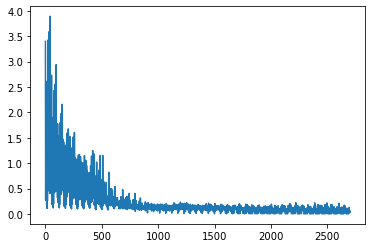

In [529]:
plt.plot(train_losses)

In [60]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Sequence Generation

In [514]:
def preprocess_task(task_vector):
    # either convert to float32 or encode to categoricals
    for i, el in enumerate(task_vector):
        try:
            task_vector[i] = float(task_vector[i])
        except:
            task_vector[i] = get_key(cat_encodings[i], task_vector[i])
    return task_vector.astype('float32')

In [515]:
def generate_solution(task_vector, save_outputs:bool=False):
  attention_plot = np.zeros((max_length_targ, max_length_feat))
  task_vector = preprocess_task(task_vector)
  inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
  result = ''

  dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
  dec_input = tf.expand_dims([1], 0)
  loss = 0
  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input
                                      , dec_hidden
                                      , inputs)
    # storing the attention weights to plot later on
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    predicted_vertice = get_key(lang, predicted_id)
    if (predicted_vertice != ' ')&(predicted_vertice != ''):
      # loss += loss_function(true_vector, predictions)
      # print(loss)
      result = predicted_vertice + ' ' + result #targ_lang.index_word[predicted_id] + ' '
    elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
      print('Evaluation: found start/end, ending')
      return result, task_vector#, attention_plot
    
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  if save_outputs:
    OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(OUTPUT_FILE, 'w') as f:
        last_vertice = ''
        for vertice in result.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_vertice = vertice
  return result, task_vector#, attention_plot

In [516]:
# i = 0
# example_task_vector = X_test.reset_index(drop=True).loc[i]
# example_true_vector = Y_test[i]
# example_true_sequence = y_test.loc[i][0]
# print('task vector: {} \n'.format(example_task_vector.values))
# print('true sequence is: {}\n'.format(example_true_sequence))
# result, task_vector = generate_solution(example_task_vector)
# print(result, '\n')
# print('length of the result sequence is: {} \n'.format(len(result.split(' '))))

### Model Evaluation

In [517]:
def generate_solution_with_evaluation(task_vector, true_vector, save_outputs:bool=False):
  # attention_plot = np.zeros((max_length_targ, max_length_feat))
  task_vector = preprocess_task(task_vector)
  inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
  result = ''

  dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
  dec_input = tf.expand_dims([1], 0)
  loss = 0
  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input
                                      , dec_hidden
                                      , inputs)
    # storing the attention weights to plot later on
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    predicted_vertice = get_key(lang, predicted_id)
    if (predicted_vertice != ' ')&(predicted_vertice != ''):
        loss += loss_function(true_vector[t], predictions)
        result = predicted_vertice + ' ' + result #targ_lang.index_word[predicted_id] + ' '
    elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
        print('Evaluation: found start/end, ending')
        return result, loss#, attention_plot
    
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  if save_outputs:
    OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(OUTPUT_FILE, 'w') as f:
        last_vertice = ''
        for vertice in result.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_ve.rtice = vertice
  return result, loss

In [518]:
i = 0
example_task_vector = X_test.reset_index(drop=True).loc[i]
example_true_vector = Y_test[i]
example_true_sequence = y_test.loc[i][0]
print('task vector: {} \n'.format(example_task_vector.values))
print('true sequence is: {}\n'.format(example_true_sequence))
result, loss = generate_solution_with_evaluation(example_task_vector, example_true_vector)
print('predicted sequence is: {}\n'.format(result))
print('predicted unique sequence is: {}\n'.format([el for i, el in enumerate(result.split(' ')) if result.split(' ')[i-1] != el]))
print('length of the result sequence is: {} \n'.format(len(result.split(' '))))
print('Cross-Entropy:', loss.numpy())

task vector: [1 2 0 1 1 0 3] 

true sequence is: show_table count_missing_values data_type_conversions train_model save_to_csv predict_on_train correct_missing_values load_from_csv compute_train_metric compute_test_metric show_table_attributes categorify choose_model_class prepare_x_and_y

predicted sequence is: <start> <start> merge time_series train_on_grid count_values count_missing_values correct_missing_values compute_test_metric define_search_space show_data_types show_table find_best_score feature_engineering install_modules find_best_model_class show_shape data_type_conversions predict_on_test import_modules groupby model_coefficients drop_column split categorify distribution commented prepare_x_and_y learning_history filter train_model save_to_csv load_from_csv compute_train_metric create_dataframe show_table_attributes 

predicted unique sequence is: ['<start>', 'merge', 'time_series', 'train_on_grid', 'count_values', 'count_missing_values', 'correct_missing_values', 'compute

In [519]:
def predict_on_test(X_test, Y_test):
    y_pred = []
    losses = []
    print('predicting..', end=' ')
    for i, task_vector in X_test.reset_index(drop=True).iterrows():
        print('{:.2%}'.format(i/X_test.shape[0]), end=' ')
        true_vector = Y_test[i]
        result, loss = generate_solution_with_evaluation(task_vector, true_vector)
        # print(loss.numpy())
        y_pred.append(result[:-1])
        losses.append(loss)
    print()
    y_pred = pd.DataFrame(y_pred, columns=[TARGET_COLUMN])
    return y_pred, losses

In [520]:
## Predict on Train
y_pred, losses = predict_on_test(X_train[TASK_FEATURES], Y_train)
print('Cross-Entropy: {}'.format(np.mean(losses)))
# print('Perplexity: {}'.format(np.mean(np.exp(losses))))
print('Unique answers: {}'.format(y_pred[TARGET_COLUMN].nunique()))

predicting.. 0.00% 1.85% 3.70% 5.56% 7.41% 9.26% 11.11% 12.96% 14.81% 16.67% 18.52% 20.37% 22.22% 24.07% 25.93% 27.78% 29.63% 31.48% 33.33% 35.19% 37.04% 38.89% 40.74% 42.59% 44.44% 46.30% 48.15% 50.00% 51.85% 53.70% 55.56% 57.41% 59.26% 61.11% 62.96% 64.81% 66.67% 68.52% 70.37% 72.22% 74.07% 75.93% 77.78% 79.63% 81.48% 83.33% 85.19% 87.04% 88.89% 90.74% 92.59% 94.44% 96.30% 98.15% 
Cross-Entropy: 183.07228088378906
Unique answers: 2


In [521]:
y_pred[TARGET_COLUMN].unique()

array(['<start> <start> merge time_series train_on_grid count_values count_missing_values correct_missing_values compute_test_metric define_search_space show_data_types show_table find_best_score feature_engineering install_modules find_best_model_class show_shape data_type_conversions predict_on_test import_modules groupby model_coefficients drop_column split categorify distribution commented prepare_x_and_y learning_history filter train_model save_to_csv load_from_csv compute_train_metric create_dataframe show_table_attributes',
       '<start> <start> <start> feature_engineering filter train_model import_modules drop_column correct_missing_values load_from_csv train_on_grid show_table_attributes categorify <start> correct_missing_values feature_engineering show_table define_constants data_type_conversions predict_on_test import_modules something_strange drop_column split categorify categorify commented prepare_x_and_y learning_history filter train_model save_to_csv load_from_csv com

In [522]:
## Predict on Test
y_pred, losses = predict_on_test(X_test[TASK_FEATURES], Y_test)
print('Cross-Entropy: {}'.format(np.mean(losses)))
# print('Perplexity: {}'.format(np.mean(np.exp(losses))))
print('Unique answers: {}'.format(y_pred[TARGET_COLUMN].nunique()))

predicting.. 0.00% 1.69% 3.39% 5.08% 6.78% 8.47% 10.17% 11.86% 13.56% 15.25% 16.95% 18.64% 20.34% 22.03% 23.73% 25.42% 27.12% 28.81% 30.51% 32.20% 33.90% 35.59% 37.29% 38.98% 40.68% 42.37% 44.07% 45.76% 47.46% 49.15% 50.85% 52.54% 54.24% 55.93% 57.63% 59.32% 61.02% 62.71% 64.41% 66.10% 67.80% 69.49% 71.19% 72.88% 74.58% 76.27% 77.97% 79.66% 81.36% 83.05% 84.75% 86.44% 88.14% 89.83% 91.53% 93.22% 94.92% 96.61% 98.31% 
Cross-Entropy: 193.2691192626953
Unique answers: 1


In [523]:
y_pred[TARGET_COLUMN].unique()

array(['<start> <start> merge time_series train_on_grid count_values count_missing_values correct_missing_values compute_test_metric define_search_space show_data_types show_table find_best_score feature_engineering install_modules find_best_model_class show_shape data_type_conversions predict_on_test import_modules groupby model_coefficients drop_column split categorify distribution commented prepare_x_and_y learning_history filter train_model save_to_csv load_from_csv compute_train_metric create_dataframe show_table_attributes'],
      dtype=object)

### Export Sequences

In [55]:
# ## save vertices to file
# TODAY = 
# OUTPUT_FILE = './task2seq/outputs/example_output_{}.py'.format(TODAY)
# with open(OUTPUT_FILE, 'w') as f:
#     last_vertice = ''
#     for vertice in result.split(' '):
#         if vertice:
#             if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
#                 line = '#@ {} \n\n'.format(vertice)
#                 f.write(line)
#                 last_vertice = vertice

---
## To Do

In [56]:
##TODO: To py and argparse

### To DAGsHub

In [57]:
##TODO: Export to DAGsHub
# experiment_params = {}
# experiment_results = {}

In [58]:
##TODO: BLEU
# def compute_bleu(reference_corpus, translation_corpus, max_order=4,
#                  smooth=False):
#   """Computes BLEU score of translated segments against one or more references.
#   Args:
#     reference_corpus: list of lists of references for each translation. Each
#         reference should be tokenized into a list of tokens.
#     translation_corpus: list of translations to score. Each translation
#         should be tokenized into a list of tokens.
#     max_order: Maximum n-gram order to use when computing BLEU score.
#     smooth: Whether or not to apply Lin et al. 2004 smoothing.
#   Returns:
#     3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
#     precisions and brevity penalty.
#   """
#   matches_by_order = [0] * max_order
#   possible_matches_by_order = [0] * max_order
#   reference_length = 0
#   translation_length = 0
#   for (references, translation) in zip(reference_corpus,
#                                        translation_corpus):
#     reference_length += min(len(r) for r in references)
#     translation_length += len(translation)

#     merged_ref_ngram_counts = collections.Counter()
#     for reference in references:
#       merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
#     translation_ngram_counts = _get_ngrams(translation, max_order)
#     overlap = translation_ngram_counts & merged_ref_ngram_counts
#     for ngram in overlap:
#       matches_by_order[len(ngram)-1] += overlap[ngram]
#     for order in range(1, max_order+1):
#       possible_matches = len(translation) - order + 1
#       if possible_matches > 0:
#         possible_matches_by_order[order-1] += possible_matches

#   precisions = [0] * max_order
#   for i in range(0, max_order):
#     if smooth:
#       precisions[i] = ((matches_by_order[i] + 1.) /
#                        (possible_matches_by_order[i] + 1.))
#     else:
#       if possible_matches_by_order[i] > 0:
#         precisions[i] = (float(matches_by_order[i]) /
#                          possible_matches_by_order[i])
#       else:
#         precisions[i] = 0.0

#   if min(precisions) > 0:
#     p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
#     geo_mean = math.exp(p_log_sum)
#   else:
#     geo_mean = 0

#   ratio = float(translation_length) / reference_length

#   if ratio > 1.0:
#     bp = 1.
#   else:
#     bp = math.exp(1 - 1. / ratio)

#   bleu = geo_mean * bp

#   return (bleu, precisions, bp, ratio, translation_length, reference_length)